## Generated figures:
* S1D (individual-mouse licking vs. time matrices)
* S1E (individual-mouse speed vs. time matrices)
* S1M, 2K (correlations in the flucations of the number of active place cells at 1 m and 3 m)

For S1D and S1E, we generate plots for days 1-4, but only day 4 is included in the supplementary materials.  
Finally, we generate a figure visualizing the mean activity levels of individual neurons as a function of days. This was used in the review response.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr

from os import sys
sys.path.append('..')
import data_util

FIG_DIR = '../figures/'

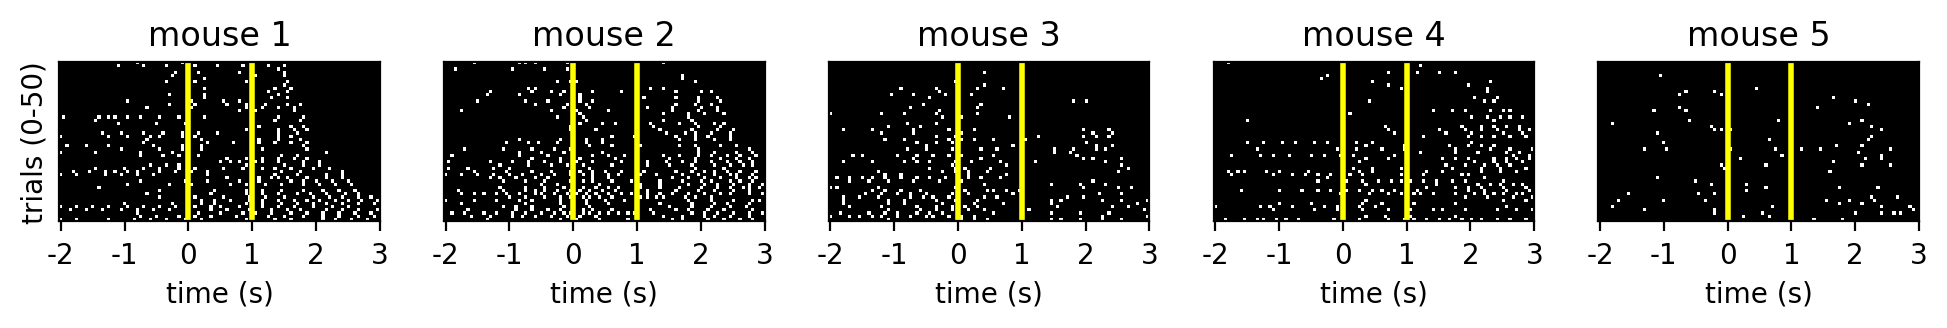

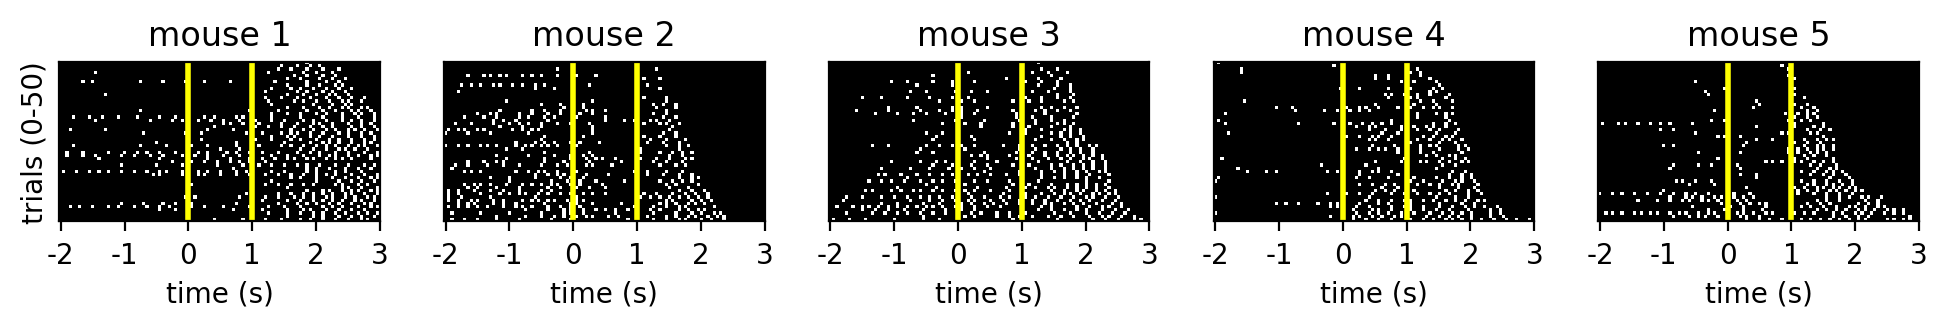

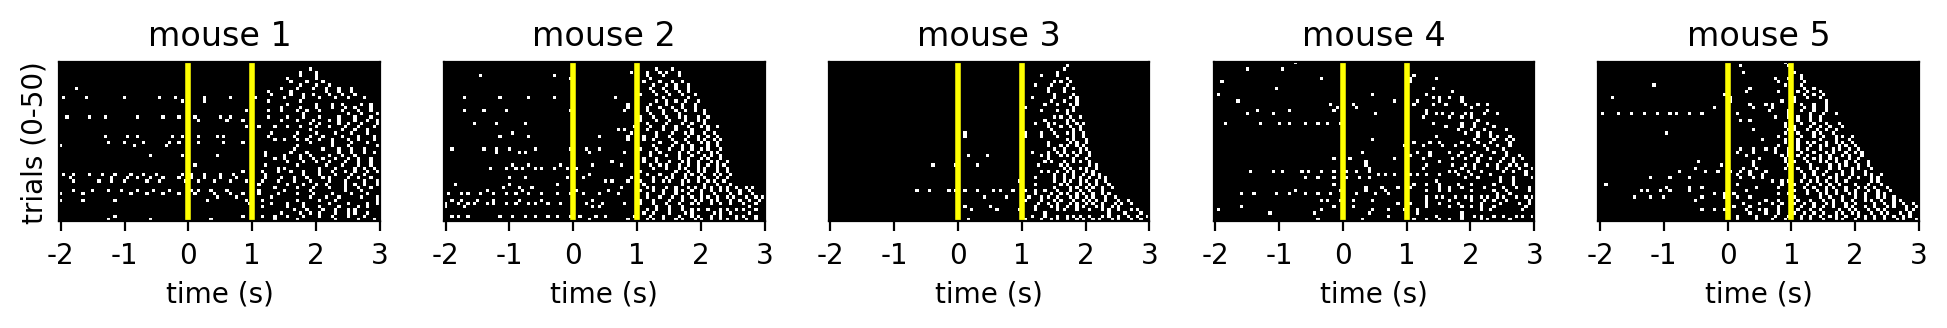

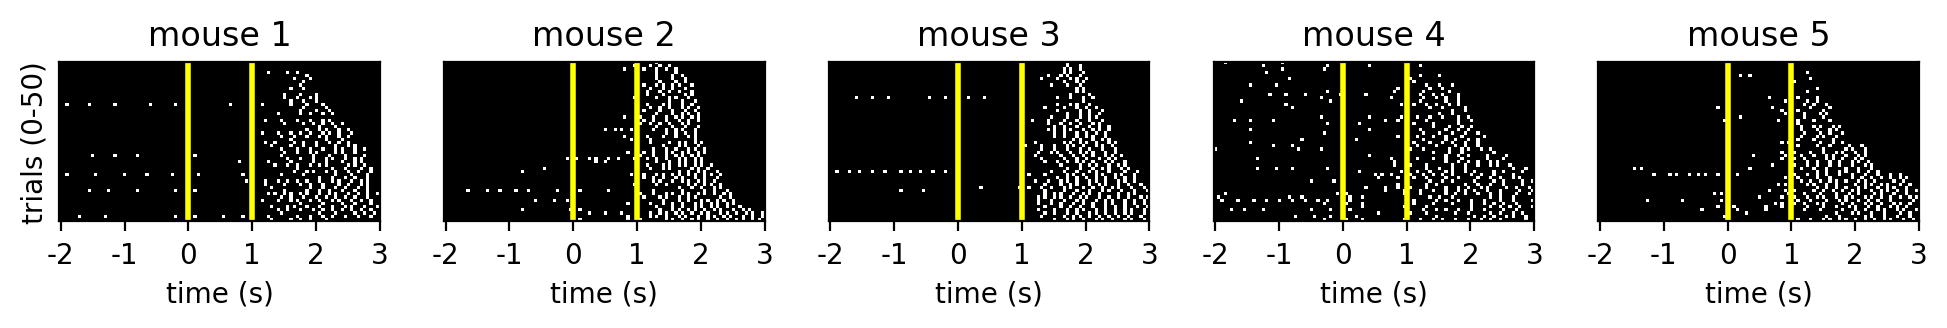

In [3]:
"""
Plot lick matrices
"""

def lick_matrix(mouse_num, day_num): #start at 1!
    data = data_util.load_single_trial_data(mouse_num=mouse_num, day_num=day_num, stop_pad=1, subset_trials=True, binarize=False)
    
    lick_trials = sum([data['lick_rate'][0][i:i+1] + data['lick_rate'][1][i:i+1] for i in range(5, 30)], [])
    pos_trials = sum([data['x'][0][i:i+1] + data['x'][1][i:i+1] for i in range(5, 30)], [])
    odor_onset_idx = np.array([np.argmax(x > 3000.) for x in pos_trials])
    lick_from_odor_onset = [lick_trials[i][odor_onset_idx[i]-40:odor_onset_idx[i]+60] for i in range(len(lick_trials))]
    pos_from_odor_onset = [pos_trials[i][odor_onset_idx[i]-40:odor_onset_idx[i]+60] for i in range(len(pos_trials))]
    
    zp = np.array([np.concatenate((x, np.zeros(100-len(x)))) for x in lick_from_odor_onset]).T
    
    finish_marks = np.array([np.argmax(p > 4000.) for p in pos_from_odor_onset])
    finish_marks[finish_marks < 50] = 1000
    
    vel_sort = np.argsort(finish_marks)
    zp = zp[:, vel_sort]
    
    return zp

def plot_lick_matrix(mat, ax, first):
    ax.imshow(mat.T, cmap="gray")
    ax.axvline(40, color="yellow", lw=2)
    ax.axvline(60, color="yellow", lw=2)
    ax.set_yticks([])
    ax.set_xlabel("time (s)")
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_xticklabels(np.arange(-2, 4))
    if first:
        ax.set_ylabel("trials (0-50)")

for day_num in range(1, 5):
    mats = [lick_matrix(mouse_num, day_num) for mouse_num in range(1, 6)]
    fig, axes = plt.subplots(1, 5, figsize=(12, 6), dpi=200)
    for i in range(5):
        ax = axes[i]
        plot_lick_matrix(mats[i], ax, first=(i == 0))
        ax.set_title("mouse {}".format(i+1))
    plt.savefig(FIG_DIR + "licking_day_{}.svg".format(day_num), bbox_inches="tight")
    plt.show()


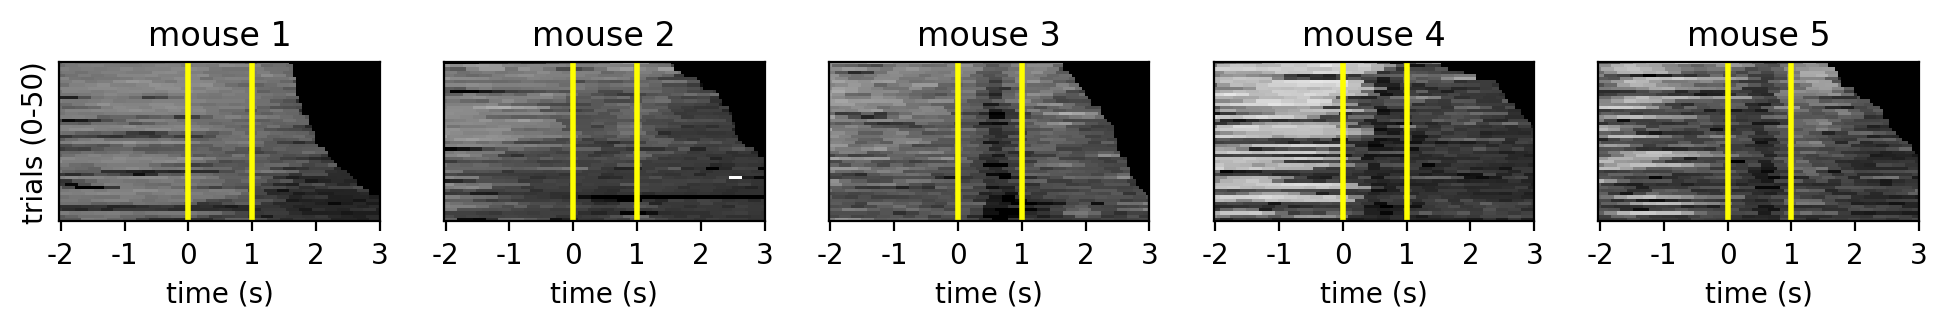

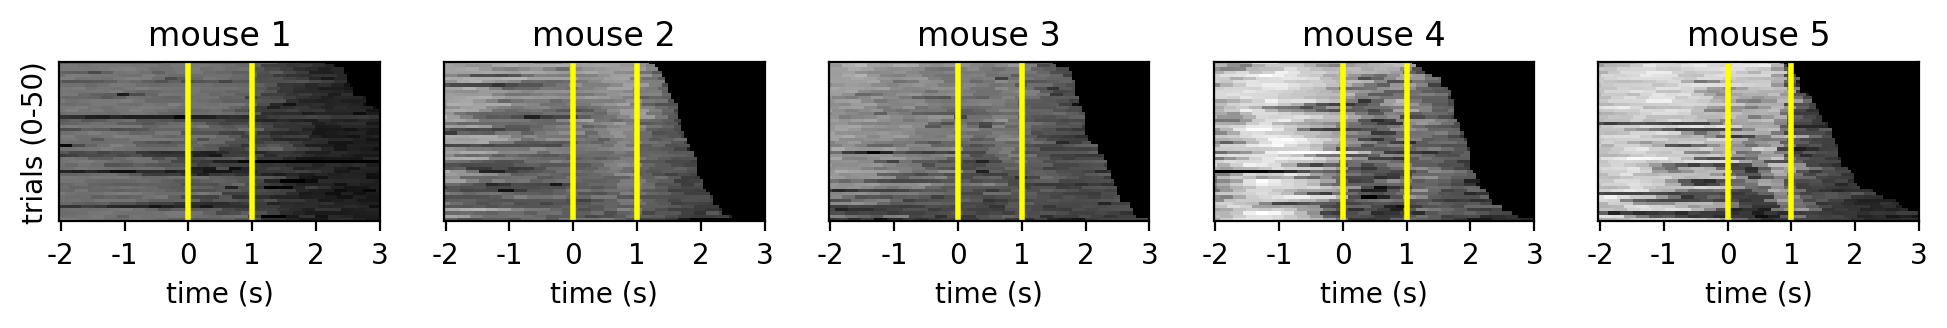

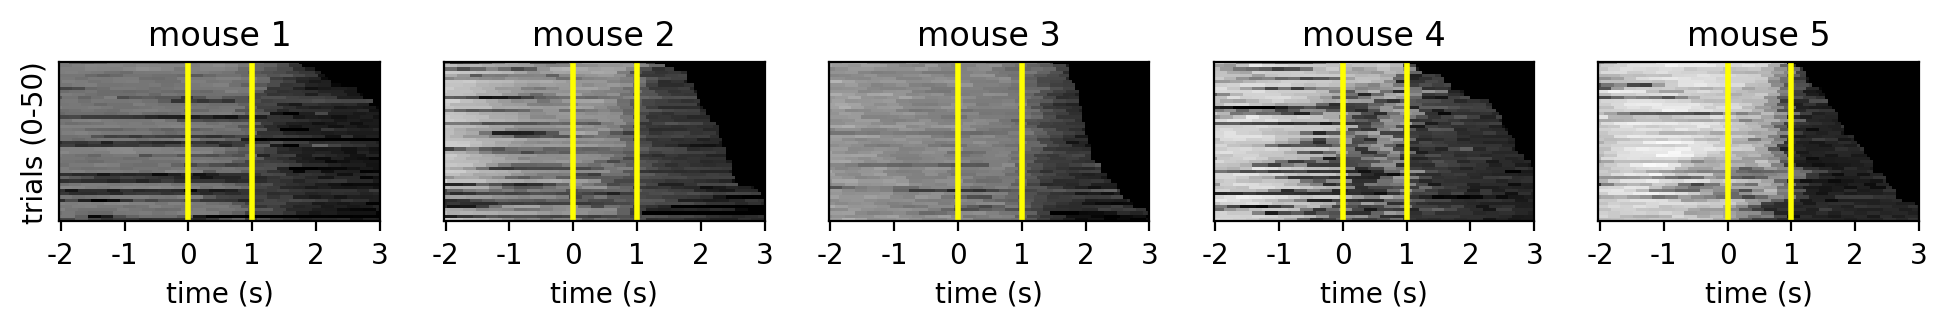

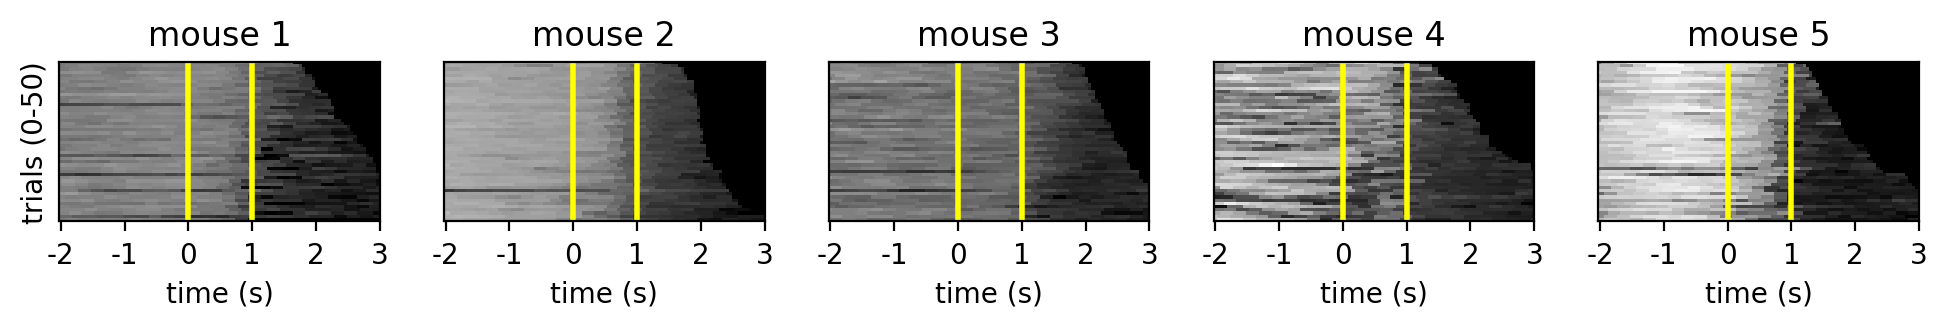

In [4]:
"""
Plot speed matrices
"""

def speed_matrix(mouse_num, day_num): #start at 1!
    data = data_util.load_single_trial_data(mouse_num=mouse_num, day_num=day_num, stop_pad=1, subset_trials=True, binarize=False)
    lick_trials = sum([data['vel'][0][i:i+1] + data['vel'][1][i:i+1] for i in range(5, 30)], [])
    pos_trials = sum([data['x'][0][i:i+1] + data['x'][1][i:i+1] for i in range(5, 30)], [])
    odor_onset_idx = np.array([np.argmax(x > 3000.) for x in pos_trials])
    lick_from_odor_onset = [lick_trials[i][odor_onset_idx[i]-40:odor_onset_idx[i]+60] for i in range(len(lick_trials))]
    pos_from_odor_onset = [pos_trials[i][odor_onset_idx[i]-40:odor_onset_idx[i]+60] for i in range(len(pos_trials))]
    zp = np.array([np.concatenate((x, np.zeros(100-len(x)))) for x in lick_from_odor_onset]).T
    finish_marks = np.array([np.argmax(p > 4000.) for p in pos_from_odor_onset])
    finish_marks[finish_marks < 50] = 1000
    vel_sort = np.argsort(finish_marks)
    zp = zp[:, vel_sort]
    return zp

def plot_speed_matrix(mat, ax, first):
    ax.imshow(mat.T, cmap="gray", vmin=0, vmax=130)
    ax.axvline(40, color="yellow", lw=2)
    ax.axvline(60, color="yellow", lw=2)
    ax.set_yticks([])
    ax.set_xlabel("time (s)")
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_xticklabels(np.arange(-2, 4))
    if first:
        ax.set_ylabel("trials (0-50)")

for day_num in range(1, 5):
    mats = [speed_matrix(mouse_num, day_num) for mouse_num in range(1, 6)]
    fig, axes = plt.subplots(1, 5, figsize=(12, 6), dpi=200)
    for i in range(5):
        ax = axes[i]
        plot_speed_matrix(mats[i], ax, first=(i == 0))
        ax.set_title("mouse {}".format(i+1))
    plt.savefig(FIG_DIR + "speed_day_{}.svg".format(day_num), bbox_inches="tight")
    plt.show()


In [5]:
"""
Correlation of z-scored flucations in the number of active cells following 1 m and 3 m.
Prints (in th next cell) correlation values with p-values for each mouse and for the combined data.
"""

def compute_num_active(trial_type, mouse_num, day_num=4):
    data = data_util.load_binned_pc_activity(mouse_num=mouse_num, day_num=4, z_score=False)[trial_type].transpose(2, 0, 1)
    data_z = data_util.load_binned_pc_activity(mouse_num=mouse_num, day_num=4, z_score=True)[trial_type].transpose(2, 0, 1)

    #Get PCs and compute centers.
    X_pc = np.copy(data)
    N_pc = len(X_pc)
    X_pc[:, :, 0] = 0.
    X_pc_avg = X_pc.mean(axis=1)
    centers = X_pc_avg[:, 1:].argmax(axis=1) + 1 #Exclude 0th bin

    odor1_mask = (centers >= 12) & (centers <= 20)
    odor2_mask = (centers >= 32) & (centers <= 40)

    #Compute and bin reliability vals (% active trials in +-1 bin)
    X_z_pc = data_z
    single_trial_reliability = np.zeros((N_pc, 25))
    for i in range(N_pc):
        c = centers[i]
        c1, c2 = c-1, c+2
        single_trial_reliability[i] = (X_z_pc[i, :, c1:c2].max(axis=1) > 1.)

    N1 = single_trial_reliability[odor1_mask].sum(axis=0)
    N2 = single_trial_reliability[odor2_mask].sum(axis=0)
    return N1, N2

all_num_active = np.zeros((5, 2, 2, 25))
for mouse_num in range(1, 6):
    for trial_type in (0, 1):
        N1, N2 = compute_num_active(trial_type, mouse_num)
        all_num_active[mouse_num-1, :, trial_type, :] = np.array([N1, N2])

(0.49696718681425484, 0.00024139205262955314)
(0.32924924374209663, 0.019555341127032316)
(0.8085046399889663, 1.2426635810434047e-12)
(-0.1169180352304855, 0.41874319653425995)
(0.6455303762193889, 4.15857844989241e-07)
(0.43266668230684424, 7.921877842640309e-13)


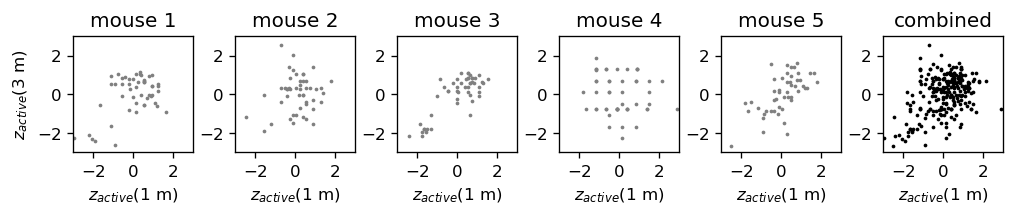

In [6]:
active_z = (all_num_active - all_num_active.mean(axis=-1, keepdims=True))/all_num_active.std(axis=-1, keepdims=True)
active_z_lp = active_z.reshape((5, 2, 50))

fig, axes = plt.subplots(1, 6, figsize=(10, 1.28), dpi=120)
plt.subplots_adjust(wspace=0.35)
for i in range(6):
    ax = axes[i]
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    if i < 5:
        ax.scatter(active_z_lp[i, 0], active_z_lp[i, 1], lw=0, s=5, color='gray')
        ax.set_title("mouse " + str(i + 1))
        r = pearsonr(active_z_lp[i, 0], active_z_lp[i, 1])
        print(r)
    else:
        ax.set_title("combined")
        ax.scatter(active_z_lp[:, 0].flatten(), active_z_lp[:, 1].flatten(), lw=0, s=5, color='black')
        r = pearsonr(active_z_lp[:, 0].flatten(), active_z_lp[:, 1].flatten())
        print(r)
    ax.set_xlabel("$z_{active}$(1 m)")
    if i == 0:
        ax.set_ylabel("$z_{active}$(3 m)")
    
plt.savefig(FIG_DIR + "pc_1m_vs_3m_updated_again.svg", bbox_inches="tight")


1.7667626995682508
1.9985556712241315
2.2575340779809085
0.9812458528388572
1.0776166533962284
mean, std = 1.6163429910016753 0.504660890777575


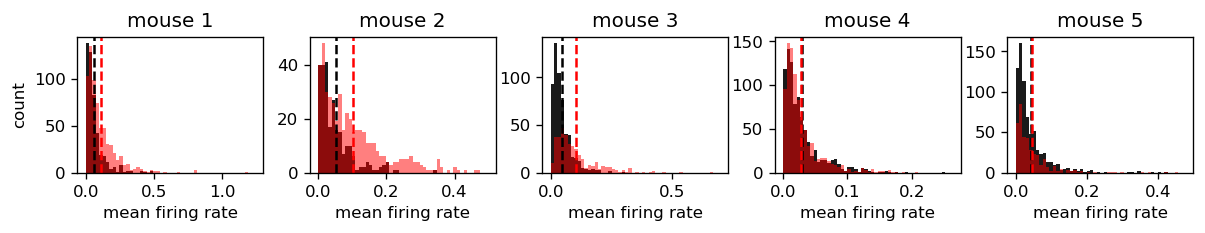

In [8]:
"""
Analysis of mean activity levels for review response
Prints ratio of day 4 activity to day 0 activity for each mouse.
"""

def plot_means(mouse_num, ax):
    X_day0 = data_util.load_and_bin_data(mouse_num, day_num=0)["neural"][0][None, ...][:, 5:, :, :]
    X_day4 = np.array(data_util.load_and_bin_data(mouse_num, day_num=4)["neural"])[:, 5:, :, :]
    means_day0 = X_day0.mean(axis=(0, 1, 2))
    means_day4 = X_day4.mean(axis=(0, 1, 2))
    vmax = np.max(np.concatenate((means_day0, means_day4)))*1.05
    ax.hist(means_day0, range=(0, vmax), bins=50, density=False, color="0.1")
    ax.hist(means_day4, range=(0, vmax), bins=50, density=False, alpha=0.5, color="red")
    ax.axvline(means_day0.mean(), color="black", ls="--")
    ax.axvline(means_day4.mean(), color="red", ls="--")
    ratio = means_day4.mean() / means_day0.mean()
    print(ratio)
    return ratio

fig, axes = plt.subplots(1, 5, figsize=(12, 1.5), dpi=120, sharey=False)
fig.subplots_adjust(wspace=0.25)
ratios = []
for i in range(5):
    ax = axes[i]
    ratio = plot_means(i, ax)
    ratios.append(ratio)
    ax.set_xlabel("mean firing rate")
    if i == 0:
        ax.set_ylabel("count")
    ax.set_title("mouse {}".format(i+1))
    
print('mean, std =', np.mean(ratios), np.std(ratios))
    
plt.savefig(FIG_DIR + "mean_activity_updated.svg", bbox_inches="tight")